In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import statsmodels.api as sm

Wczytaj dane opisujące ilość plam słonecznych w okresie od 1700 do 2008 r.

In [5]:
import pandas as pd
series = pd.read_csv('./sunspots.csv', index_col = 'YEAR', squeeze = True, parse_dates=['YEAR'])

# series = Series.from_csv('./sunspots.csv', header=0)
series.head()

YEAR
1700-01-01     5.0
1701-01-01    11.0
1702-01-01    16.0
1703-01-01    23.0
1704-01-01    36.0
Name: SUNACTIVITY, dtype: float64

In [6]:
series.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
series.index

DatetimeIndex(['1700-12-31', '1701-12-31', '1702-12-31', '1703-12-31',
               '1704-12-31', '1705-12-31', '1706-12-31', '1707-12-31',
               '1708-12-31', '1709-12-31',
               ...
               '1999-12-31', '2000-12-31', '2001-12-31', '2002-12-31',
               '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31',
               '2007-12-31', '2008-12-31'],
              dtype='datetime64[ns]', length=309, freq=None)

# Zadanie
Narysuj szereg czasowy

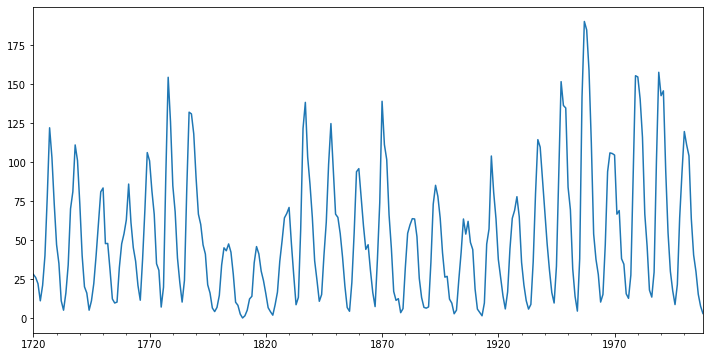

In [7]:
plt.figure(figsize=(12,6));
series.loc['1720':].plot()
plt.show()

### Zanim zdecydujemy, który model ma być używany, musimy przyjrzeć się autokorelacji.

Poleca się stosowanie następujących zasad:

<b>Zasada 1:</b> Jeśli ACF wykazuje rozkłady wykładnicze, a PACF ma skok przy opóźnieniu 1 oraz nie ma korelacji dla innych opóźnień to użyj jednego parametru autoregresji (p).

<b>Zasada 2:</b> Jeśli ACF ma kształt sinusoidy lub powtarzający się wzorzec w kształcie funkcji wykładniczej, a PACF ma skoki przy opóźnieniach 1 i 2 oraz nie ma korelacji dla innych opóźnień to użyj parametrów autoregresji (p) równej dwa.

<b>Zasada 3:</b> Jeśli ACF ma skok w punkcie 1 i nie ma korelacji z innymi opóźnieniami, a PACF maleje wykładniczo to użyj parametru średniej ruchomej (q) równego jeden.

<b>Zasada 4:</b> Jeśli ACF ma skoki przy opóźnieniach 1 i 2 i nie ma korelacji z innymi opóźnieniami, a PACF ma kształt sinusoidy lub zespół rozkładów wykładniczych to użyj parametrów średniej ruchomej (q) równej dwa.

<b>Zasada 5:</b> Jeśli ACF i PACF wygląda jak funkcja wykładnicza zaczynająca się od opóźnienia 1 to użyj parametru autoregresji (p =1) i parametru średniej ruchu (q=1).



# Zadanie
Narysuj funkcję:
- ACF
- PACF

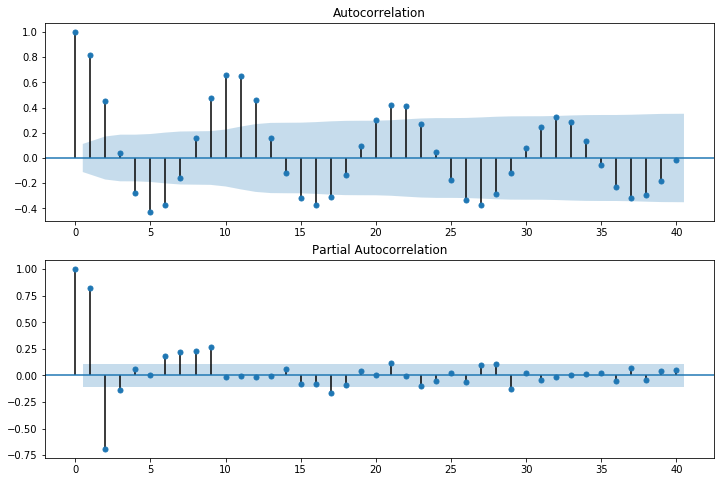

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series.values, lags=40, ax=ax2)
plt.show()

### Statystyka Durbin-Watson

- Innym popularnym testem korelacji szeregowej jest statystyka Durbin-Watson. Statystyczna wartość DW mieści się w przedziale 0-4. 
- Dodatnia korelacja jest związana z wartościami DW poniżej 2 a ujemna korelacja z wartościami DW powyżej 2.
- Wartość statystyki Durbin-Watson wynosi blisko 2, jeśli błędy nie są ze sobą powiązane.

# Zadanie
Wykonaj test Durbina Watsona

In [9]:
sm.stats.durbin_watson(series)

0.13952892659903304

# AR(2) = ARMA(2,0)

Korzystając z zasady 2, najpierw spróbujemy model ARMA(2,0) z dwoma warunkami autoregresji i bez średnich kroczących.

In [10]:
arma_mod20 = sm.tsa.ARMA(series, (2,0)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


Wypiszmy parametry modelu

In [11]:
print(arma_mod20.params)

const                49.659312
ar.L1.SUNACTIVITY     1.390656
ar.L2.SUNACTIVITY    -0.688571
dtype: float64


Teraz obliczamy Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC) oraz Hannan-Quinn Information Criterion (HQIC). Naszym celem jest wybranie modelu, który minimalizuje (AIC, BIC, HQIC).

In [12]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

2622.6363380644107 2637.5697031720015 2628.6067259096567


# Analiza Residuals

Test Durbin-Watson nie wykazuje autokorelacji.

In [13]:
sm.stats.durbin_watson(arma_mod20.resid.values)

2.145826833998379

Możemy narysować błędy (Residuals)

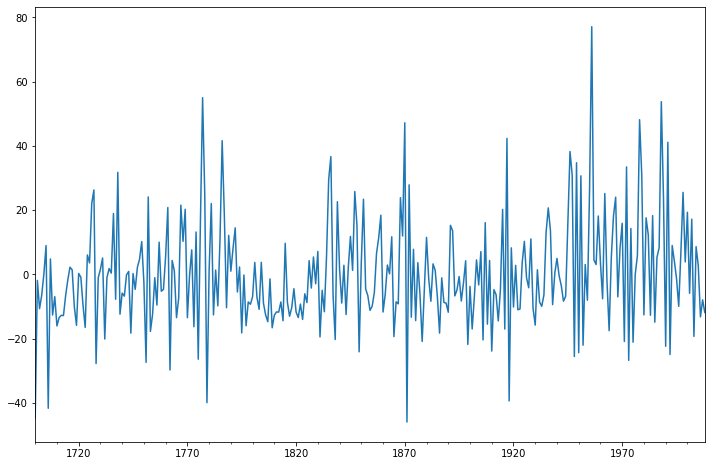

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod20.resid.plot(ax=ax);
plt.show()

Możemy sprawdzić założeni o rozkładzie normalnym błędów.

In [15]:
import scipy.stats as stats
resid20 = arma_mod20.resid
stats.normaltest(resid20)

NormaltestResult(statistic=41.73603412944527, pvalue=8.652375133995179e-10)

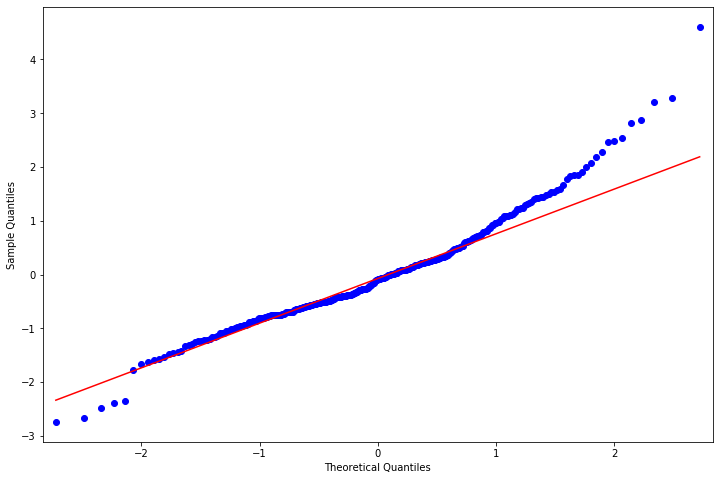

In [16]:
from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid20, line='q', ax=ax, fit=True)
plt.show()

Możemy sprawdzić autokorelację dla błędów

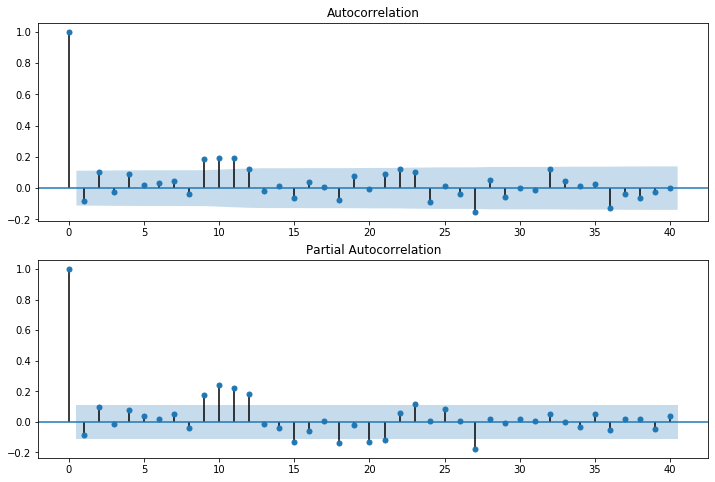

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid20.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid20.values, lags=40, ax=ax2)
plt.show()

Możemy wypisać pełna informację o modelu:

In [18]:
print(arma_mod20.summary())

                              ARMA Model Results                              
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                     ARMA(2, 0)   Log Likelihood               -1307.318
Method:                       css-mle   S.D. of innovations             16.576
Date:                Sun, 22 Mar 2020   AIC                           2622.636
Time:                        12:54:36   BIC                           2637.570
Sample:                    12-31-1700   HQIC                          2628.607
                         - 12-31-2008                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                49.6593      3.165     15.689      0.000      43.456      55.863
ar.L1.SUNACTIVITY     1.3907      0.041     33.954      0.000       1.310       1.471
ar.L2.SUNACTIVITY    -0.

## Wykonajmy predykcję 

In [19]:
predict_sunspots20 = arma_mod20.predict('1990', '2012', dynamic=True)
print(predict_sunspots20)

1990-12-31    164.966782
1991-12-31    135.687458
1992-12-31     89.897448
1993-12-31     46.380209
1994-12-31     17.392393
1995-12-31      7.045034
1996-12-31     12.615594
1997-12-31     27.487217
1998-12-31     44.332796
1999-12-31     57.519026
2000-12-31     64.257153
2001-12-31     64.547910
2002-12-31     60.312573
2003-12-31     54.222472
2004-12-31     48.669569
2005-12-31     45.140860
2006-12-31     44.057210
2007-12-31     44.979993
2008-12-31     47.009436
2009-12-31     49.196291
2010-12-31     50.840037
2011-12-31     51.620117
2012-12-31     51.573104
Freq: A-DEC, dtype: float64


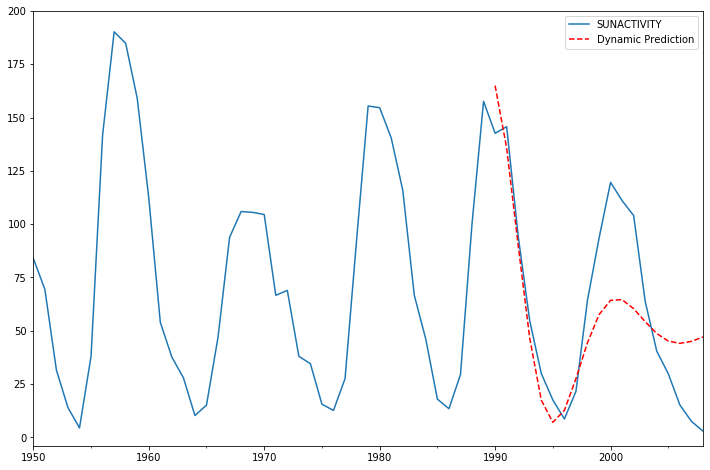

In [20]:
ax = series.loc['1950':].plot(figsize=(12,8))
predict_sunspots20.plot(ax=ax, style='r--', label='Dynamic Prediction');
ax.legend();
ax.axis((-20.0, 38.0, -4.0, 200.0));
plt.show()

Możemy policzyć jeszcze błąd:

In [21]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()
def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or percent error = * 100

In [22]:
print("MFE = ", mean_forecast_err(series, predict_sunspots20))
print ("MAE = ", mean_absolute_err(series, predict_sunspots20))

MFE =  4.730466829920653
MAE =  0.13469171014105097


# Zadanie
Naucz model ARMA(3,0) oraz:
- wykonaj test Durbin-Watsona
- sprawdź korelację dla błędów
- wykonaj predykcję

# Zadanie
Naucz model ARMA(2,1) oraz:
- wykonaj test Durbin-Watsona
- sprawdź korelację dla błędów
- wykonaj predykcję

# Zadanie
Naucz model ARMA(2,3) oraz:
- wykonaj test Durbin-Watsona
- sprawdź korelację dla błędów
- wykonaj predykcję

# Zadanie
Naucz model ARMA(3,2) oraz:
- wykonaj test Durbin-Watsona
- sprawdź korelację dla błędów
- wykonaj predykcję

# Wnioski

Oczywiście model 5 minimalizuje (aic, bic, hqic). 

Model 1 ma jednak najmniejszy MFE i MAE. 

Pod względem konsystencji model 2 minimalizuje AIC, BIC, HQIC, MFE i MAE. 

Również ARIMA(3,0,2) ma najmniejsze wartości AIC, BIC i HQIC, choć widać nadmieny overfiting. 

Zauważ, że ARIMA(2,0,3) i ARMA(2,3) to te same modele.

# Można sprawdzać wiele modeli:

In [110]:
arma_mod10 = sm.tsa.ARMA(series, (1,0)).fit()
arma_mod20 = sm.tsa.ARMA(series, (2,0)).fit()
arma_mod30 = sm.tsa.ARMA(series, (3,0)).fit()
arma_mod40 = sm.tsa.ARMA(series, (2,1)).fit()
arma_mod50 = sm.tsa.ARMA(series, (2,3)).fit()
arima_mod1 = sm.tsa.ARIMA(series, (3,0,2)).fit()
arima_mod2 = sm.tsa.ARIMA(series, (2,0,2)).fit()
arima_mod3 = sm.tsa.ARIMA(series, (1,0,0)).fit()
arima_mod4 = sm.tsa.ARIMA(series, (0,1,0)).fit()
arima_mod5 = sm.tsa.ARIMA(series, (0,0,1)).fit()
arima_mod6 = sm.tsa.ARIMA(series, (1,1,0)).fit()
arima_mod7 = sm.tsa.ARIMA(series, (0,1,1)).fit()
arima_mod8 = sm.tsa.ARIMA(series, (1,1,1)).fit()
arima_mod9 = sm.tsa.ARIMA(series, (3,0,3)).fit()
arima_mod10= sm.tsa.ARIMA(series, (1,0,6)).fit()
arima_mod11= sm.tsa.ARIMA(series, (1,0,3)).fit()

In [111]:
print("Model 01: ARMA(1,0)     AIC", arma_mod20.aic, " BIC", arma_mod20.bic, " HQIC", arma_mod20.hqic)
print("Model 02: ARMA(2,0)     AIC", arma_mod20.aic, " BIC", arma_mod20.bic, " HQIC", arma_mod20.hqic)
print("Model 03: ARMA(3,0)     AIC", arma_mod30.aic, " BIC", arma_mod30.bic, " HQIC", arma_mod30.hqic)
print("Model 04: ARMA(2,1)     AIC", arma_mod40.aic, "BIC", arma_mod40.bic, " HQIC", arma_mod40.hqic)
print("Model 05: ARMA(2,3)     AIC", arma_mod50.aic, " BIC", arma_mod50.bic, " HQIC", arma_mod50.hqic)
print("Model 06: ARIMA(3,0,2)  AIC", arima_mod1.aic, " BIC", arima_mod1.bic, " HQIC", arima_mod1.hqic)
print("Model 07: ARIMA(2,0,2)  AIC", arima_mod2.aic, " BIC", arima_mod2.bic, " HQIC", arima_mod2.hqic)
print("Model 08: ARIMA(1,0,0)  AIC", arima_mod3.aic, " BIC", arima_mod3.bic, " HQIC", arima_mod3.hqic)
print("Model 09: ARIMA(0,1,0)  AIC", arima_mod4.aic, " BIC", arima_mod4.bic, " HQIC", arima_mod4.hqic)
print("Model 10: ARIMA(0,0,1)  AIC", arima_mod5.aic, " BIC", arima_mod5.bic, " HQIC", arima_mod5.hqic)
print("Model 11: ARIMA(1,1,0)  AIC", arima_mod6.aic, " BIC", arima_mod6.bic, " HQIC", arima_mod6.hqic)
print("Model 12: ARIMA(0,1,1)  AIC", arima_mod7.aic, " BIC", arima_mod7.bic, " HQIC", arima_mod7.hqic)
print("Model 13: ARIMA(1,1,1)  AIC", arima_mod8.aic, " BIC", arima_mod8.bic, " HQIC", arima_mod8.hqic)
print("Model 14: ARIMA(3,0,3)  AIC", arima_mod9.aic, " BIC", arima_mod9.bic, " HQIC", arima_mod9.hqic)
print("Model 15: ARIMA(1,0,6)  AIC", arima_mod10.aic, " BIC", arima_mod10.bic, " HQIC", arima_mod10.hqic)
print("Model 16: ARIMA(1,0,3)  AIC", arima_mod11.aic, " BIC", arima_mod11.bic, " HQIC", arima_mod11.hqic)

Model 01: ARMA(1,0)     AIC 2622.6363380639814  BIC 2637.56970317  HQIC 2628.60672591
Model 02: ARMA(2,0)     AIC 2622.6363380639814  BIC 2637.56970317  HQIC 2628.60672591
Model 03: ARMA(3,0)     AIC 2619.403628696475  BIC 2638.07033508  HQIC 2626.8666135
Model 04: ARMA(2,1)     AIC 2620.277191556711 BIC 2638.94389794  HQIC 2627.74017636
Model 05: ARMA(2,3)     AIC 2622.8516907827516  BIC 2648.98507972  HQIC 2633.29986951
Model 06: ARIMA(3,0,2)  AIC 2581.5722990083814  BIC 2607.70568795  HQIC 2592.02047774
Model 07: ARIMA(2,0,2)  AIC 2620.872695816994  BIC 2643.27274348  HQIC 2629.82827758
Model 08: ARIMA(1,0,0)  AIC 2819.169152442845  BIC 2830.36917627  HQIC 2823.64694333
Model 09: ARIMA(0,1,0)  AIC 2835.1157734  BIC 2842.57597297  HQIC 2838.09870518
Model 10: ARIMA(0,0,1)  AIC 2886.9006685925715  BIC 2898.10069242  HQIC 2891.37845948
Model 11: ARIMA(1,1,0)  AIC 2730.689777420153  BIC 2741.88007677  HQIC 2735.16417509
Model 12: ARIMA(0,1,1)  AIC 2743.278276627907  BIC 2754.46857598  H

In [112]:
predict_sunspots10 = arma_mod10.predict('1990', '2012', dynamic=True)
predict_sunspots20 = arma_mod20.predict('1990', '2012', dynamic=True)
predict_sunspots30 = arma_mod30.predict('1990', '2012', dynamic=True)
predict_sunspots40 = arma_mod40.predict('1990', '2012', dynamic=True)
predict_sunspots50 = arma_mod50.predict('1990', '2012', dynamic=True)
predict_sunspots1 = arima_mod1.predict('1990', '2012', dynamic=True)
predict_sunspots2 = arima_mod2.predict('1990', '2012', dynamic=True)
predict_sunspots3 = arima_mod3.predict('1990', '2012', dynamic=True)
predict_sunspots4 = arima_mod4.predict('1990', '2012', dynamic=True)
predict_sunspots5 = arima_mod5.predict('1990', '2012', dynamic=True)
predict_sunspots6 = arima_mod6.predict('1990', '2012', dynamic=True)
predict_sunspots7 = arima_mod7.predict('1990', '2012', dynamic=True)
predict_sunspots8 = arima_mod8.predict('1990', '2012', dynamic=True)
predict_sunspots9 = arima_mod9.predict('1990', '2012', dynamic=True)
predict_sunspots10 = arima_mod10.predict('1990', '2012', dynamic=True)
predict_sunspots11 = arima_mod11.predict('1990', '2012', dynamic=True)

D:\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


In [114]:
print("Metrics for Model 01 ARMA(1,0):    ",mean_forecast_err(series, predict_sunspots10)," MFE  ", mean_absolute_err(series, predict_sunspots10),"MAE") 
print("Metrics for Model 02 ARMA(2,0):    ",mean_forecast_err(series, predict_sunspots20)," MFE  ", mean_absolute_err(series, predict_sunspots20),"MAE") 
print("Metrics for Model 03 ARMA(3,0):    ",mean_forecast_err(series, predict_sunspots30)," MFE  ", mean_absolute_err(series, predict_sunspots30),"MAE") 
print("Metrics for Model 04 ARMA(2,1):    ",mean_forecast_err(series, predict_sunspots40)," MFE  ", mean_absolute_err(series, predict_sunspots40),"MAE") 
print("Metrics for Model 05 ARMA(2,3):    ",mean_forecast_err(series, predict_sunspots50)," MFE  ", mean_absolute_err(series, predict_sunspots50),"MAE") 
print("Metrics for Model 06 ARIMA(3,0,2): ",mean_forecast_err(series, predict_sunspots1)," MFE  ", mean_absolute_err(series, predict_sunspots1),"MAE") 
print("Metrics for Model 07 ARIMA(2,0,2): ",mean_forecast_err(series, predict_sunspots2)," MFE  ", mean_absolute_err(series, predict_sunspots2),"MAE") 
print("Metrics for Model 08 ARIMA(1,0,0): ",mean_forecast_err(series, predict_sunspots3)," MFE  ", mean_absolute_err(series, predict_sunspots3),"MAE") 
print("Metrics for Model 09 ARIMA(0,1,0): ",mean_forecast_err(series, predict_sunspots4)," MFE  ", mean_absolute_err(series, predict_sunspots4),"MAE")
print("Metrics for Model 10 ARIMA(0,0,1): ",mean_forecast_err(series, predict_sunspots5)," MFE  ", mean_absolute_err(series, predict_sunspots5),"MAE") 
print("Metrics for Model 11 ARIMA(1,1,0): ",mean_forecast_err(series, predict_sunspots6)," MFE  ", mean_absolute_err(series, predict_sunspots6),"MAE") 
print("Metrics for Model 12 ARIMA(0,1,1): ",mean_forecast_err(series, predict_sunspots7)," MFE  ", mean_absolute_err(series, predict_sunspots7),"MAE") 
print("Metrics for Model 13 ARIMA(1,1,1): ",mean_forecast_err(series, predict_sunspots8)," MFE  ", mean_absolute_err(series, predict_sunspots8),"MAE") 
print("Metrics for Model 14 ARIMA(3,0,3): ",mean_forecast_err(series, predict_sunspots9)," MFE  ", mean_absolute_err(series, predict_sunspots9),"MAE") 
print("Metrics for Model 15 ARIMA(1,0,6): ",mean_forecast_err(series, predict_sunspots10)," MFE  ", mean_absolute_err(series, predict_sunspots10),"MAE") 
print("Metrics for Model 16 ARIMA(1,0,3): ",mean_forecast_err(series, predict_sunspots11)," MFE  ", mean_absolute_err(series, predict_sunspots11),"MAE") 
      

Metrics for Model 01 ARMA(1,0):     2.4634783413409793  MFE   0.04916314201861694 MAE
Metrics for Model 02 ARMA(2,0):     4.730437376819153  MFE   0.1346906768301532 MAE
Metrics for Model 03 ARMA(3,0):     5.636961675275295  MFE   -0.14113178723355474 MAE
Metrics for Model 04 ARMA(2,1):     5.651928894195339  MFE   4.822612667552202 MAE
Metrics for Model 05 ARMA(2,3):     5.277557122851105  MFE   0.3252746315891806 MAE
Metrics for Model 06 ARIMA(3,0,2):  -13.393742649130314  MFE   0.3574317181679279 MAE
Metrics for Model 07 ARIMA(2,0,2):  5.26202469738349  MFE   0.21582775732783616 MAE
Metrics for Model 08 ARIMA(1,0,0):  -13.30964247301857  MFE   0.2074590952264925 MAE
Metrics for Model 09 ARIMA(0,1,0):  61.3962918660287  MFE   -9004.789473684332 MAE
Metrics for Model 10 ARIMA(0,0,1):  9.301487227138372  MFE   0.1835444054943031 MAE
Metrics for Model 11 ARIMA(1,1,0):  57.850286822844126  MFE   19238.720551322334 MAE
Metrics for Model 12 ARIMA(0,1,1):  60.73063670130523  MFE   -17762.63